In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import seaborn as sns

from tqdm.auto import tqdm
from cai_garland.utils.translator import Translator

/home/eeisenst/workspace/transformers/src/transformers/models/bart/modeling_bart.py:549: FutureWarning: The class `PretrainedBartModel` has been depreciated, please use `BartPreTrainedModel` instead.
  warnings.warn(


In [2]:
# translator = Translator('olive-cormorant-nllb/base-600M')
translator = Translator('olive-cormorant-nllb/base-600M-aug')
translator.num_beams = 50
translator.decoding_length = 200
# translator.prepare_context_encoder(cfg.generation.generation.pooled_context.context_encoder.hf_model_name)
translator.cuda()

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 90592. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Config of the decoder: <class 'cai_garland.models.pooled_context_decoder_m2m.M2MWithPooledContextForCausalLM'> is overwritten by shared decoder config: M2MWithPooledContextForCausalLMConfig {
  "_name_or_path": "facebook/nllb-200-distilled-600M",
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "architectures": [
    "M2M100ForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "context_architecture": "no-context-injection",
  "d_model": 1024,
  "decoder_attention_heads": 1

In [3]:
def stats_for_line(line, translator, beam_idxs=None):
    with warnings.catch_warnings(record=True):
        translation, stats = translator.translate(
            line,
            generator_kwargs={
                'repetition_penalty': 2.2,
                'no_repeat_ngram_size': 3,
                # 'penalty_alpha': 0.6,
                # 'top_k': 10,
                # 'do_sample': True,
                # 'num_beam_groups': 10,
                # 'diversity_penalty': 1.0,
                'output_hidden_states': True,
                'output_attentions': True
            },
            return_full_results=True
        )

    df_dict = {
        'layer_idx': [],
        'head_idx': [],
        'beam_idx': [],
        'sub_dim': [],
        'act_mean': [],
        'act_stdev': [],
        'act_meandev': [],
        'act_min': [],
        'act_max': [],
        'act_range': [],
    }

    for layer_idx, layer in enumerate(stats.decoder_hidden_states):
        for head_idx, head in enumerate(layer):
            head = head.cpu().numpy()
            for beam_idx, beam in enumerate(head):
                if beam_idxs is None or beam_idx in beam_idxs:
                    for sub_dim, act in enumerate(beam):
                        df_dict['layer_idx'].append(layer_idx)
                        df_dict['head_idx'].append(head_idx)
                        df_dict['beam_idx'].append(beam_idx)
                        df_dict['sub_dim'].append(sub_dim)
                        df_dict['act_mean'].append(act.mean())
                        df_dict['act_stdev'].append(act.std())
                        df_dict['act_meandev'].append(np.absolute(act).mean())
                        df_dict['act_min'].append(act.min())
                        df_dict['act_max'].append(act.max())
                        df_dict['act_range'].append(act.ptp())

    return translation, pd.DataFrame(df_dict).set_index(['layer_idx', 'head_idx', 'beam_idx', 'sub_dim'])

In [4]:
def aggregated_df(bos, translator):
    df_dict = {
        "line": [],
        "translation": [],
        "stat": [],
        "stat2": []
    }

    for control_bo in tqdm(bos):
        translation, stats_df = stats_for_line(control_bo, translator)#, beam_idxs=range(10))

        # This appears to detect formulaic meaningless sequences of tokens, like long lists of epithets or Sanskrit gobbledigook
        # stat = stats_df.act_max.mean()

        # Most negative activation seems to be the best at detecting both gobbledigook and memorized phrases
        # stat = stats_df.act_min.mean()

        # stat = (stats_df.act_stdev / stats_df.act_meandev).mean()

        # For the bad stuff, the range seems smaller too - see control doc versus test doc
        # stat2 = stats_df.act_range.mean()
        # stat2 = stats_df.act_mean.mean()

        # This is for figuring out the regularization lambda
        stat = stats_df.act_meandev.mean()
        stat2 = stats_df.act_mean.mean()
        
        df_dict["line"].append(control_bo)
        df_dict["translation"].append(translation)
        df_dict["stat"].append(stat)
        df_dict["stat2"].append(stat2)

    return pd.DataFrame(df_dict)

In [5]:
def compute_loss(bo, en, translator):
    bo_tokens = translator.tokenizer(bo, return_tensors="pt")
    with translator.tokenizer.as_target_tokenizer():
        en_tokens = translator.tokenizer(en, return_tensors="pt")
    model_inputs = {
        'input_ids': bo_tokens.input_ids.to(translator.model.device),
        'attention_mask': bo_tokens.attention_mask.to(translator.model.device),
        'labels': en_tokens['input_ids'].to(translator.model.device),
    }
    return -float(translator.model(**model_inputs).loss.to("cpu"))

## Classifier guidance setup

In [6]:
guide_translator = Translator('olive-cormorant-nllb/base-600M')
guide_classifier = guide_translator.model
# guide.num_beams = 50
# guide.decoding_length = 200
# guide.cuda()

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 90592. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Config of the decoder: <class 'cai_garland.models.pooled_context_decoder_m2m.M2MWithPooledContextForCausalLM'> is overwritten by shared decoder config: M2MWithPooledContextForCausalLMConfig {
  "_name_or_path": "facebook/nllb-200-distilled-600M",
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "architectures": [
    "M2M100ForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "context_architecture": "no-context-injection",
  "d_model": 1024,
  "decoder_attention_heads": 1

In [7]:
from transformers import LogitsProcessor, LogitsProcessorList

import torch
from torch.nn import CrossEntropyLoss

class ClassifierGuidedLogitsProcessor(LogitsProcessor):
    source_tokens = None
    guidance_scale = 0.8

    def __init__(self, guidance_classifier):
        super().__init__()
        self.guidance_classifier = guidance_classifier
    
    def __call__(self, input_ids, scores):
        if self.source_tokens is None:
            raise ValueError("Do not forget to set source_tokens before translating with classifier guidance")
        model_inputs = {
            'input_ids': self.source_tokens.input_ids.repeat(input_ids.size()[0], 1).to(self.guidance_classifier.device),
            'attention_mask': self.source_tokens.attention_mask.repeat(input_ids.size()[0], 1).to(self.guidance_classifier.device),
            'labels': input_ids.to(self.guidance_classifier.device),
        }
        self.labels = model_inputs["labels"]
        self.guide_scores = self.guidance_classifier(**model_inputs)#.loss.to("cpu")
        # self.new_scores = scores - self.guidance_scale * self.guide_scores.logits.to(scores)[:,-1]
        self.new_scores = self.guide_scores.logits.to(scores)[:,-1]
        
        return self.new_scores

In [8]:
cg_logits_proc = ClassifierGuidedLogitsProcessor(guide_classifier)

## Label smoothing

In [6]:
from transformers import LogitsProcessor, LogitsProcessorList

import torch
from torch.nn import CrossEntropyLoss
from torch.nn.functional import softmax, log_softmax

class LabelSmoothingLogitsProcessor(LogitsProcessor):
    source_tokens = None

    def __init__(self, smoothing_factor):
        super().__init__()
        self.smoothing_factor = smoothing_factor
    
    def __call__(self, input_ids, scores):
        # Smoothing in probability space
        # scores = softmax(scores, dim=-1)
        # scores = torch.clamp(scores, max=self.smoothing_factor)
        # scores = (scores / scores.sum(dim=1).view(-1, 1))
        # scores = torch.log(scores)

        # Smoothing in logit space
        scores = torch.clamp(scores, max=-self.smoothing_factor)

        # print(torch.max(scores))
        # print(torch.max(scores, dim=1)[0])
        # print(torch.clamp(scores, max=-0.5))
        # return scores + self.smoothing_factor
        return scores

## Re-ranking

In [7]:
reranker = Translator('olive-cormorant-nllb/base-600M')
# reranker.num_beams = 50
# reranker.decoding_length = 200
# reranker.cuda()

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 90592. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Config of the decoder: <class 'cai_garland.models.pooled_context_decoder_m2m.M2MWithPooledContextForCausalLM'> is overwritten by shared decoder config: M2MWithPooledContextForCausalLMConfig {
  "_name_or_path": "facebook/nllb-200-distilled-600M",
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "architectures": [
    "M2M100ForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "context_architecture": "no-context-injection",
  "d_model": 1024,
  "decoder_attention_heads": 1

In [8]:
def rerank(source, candidates, reranker, num_return_sequences=1, add_scores=False):
    losses = [(candidate, compute_loss(source, candidate, reranker)) for candidate in tqdm(candidates)]
    losses = list(sorted(losses, key = lambda x: -x[1]))

    if add_scores:
        results = list(map(lambda x: x[0] + '|' + str(x[1]), losses))
    else:
        results = list(map(lambda x: x[0], losses))
    
    if num_return_sequences == 1:
        return results[0]
    return results[:num_return_sequences]

# Sample

## Heatmaps

In [7]:
# control
line = "།མཐོང་མ་ཐག་ཏུ་ཡང་དེ་རྣམས་བཅོམ་ལྡན་འདས་ལ་སེམས་དང་བ་ཆེན་པོ་སྐྱེས་སོ།"

In [8]:
# translation, stats = translator.translate(
#     line, generator_kwargs={'repetition_penalty': 2.2, 'no_repeat_ngram_size': 3}, return_full_results=True
# )

# translation, stats = translator.translate(
#     line, generator_kwargs={'num_beam_groups': 10, 'max_new_tokens': 200, 'diversity_penalty': 1.0}, return_full_results=True
# )

translation, stats = translator.translate(
    line,
    generator_kwargs={
        'repetition_penalty': 2.2,
        'no_repeat_ngram_size': 3,
        # 'penalty_alpha': 0.6,
        # 'top_k': 10,
        # 'do_sample': True,
        'num_beam_groups': 10,
        'diversity_penalty': 1.0,
        'output_hidden_states': True,
        'output_attentions': True
    },
    return_full_results=True
)

line, translation

/home/eeisenst/workspace/transformers/src/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


('།མཐོང་མ་ཐག་ཏུ་ཡང་དེ་རྣམས་བཅོམ་ལྡན་འདས་ལ་སེམས་དང་བ་ཆེན་པོ་སྐྱེས་སོ།',
 'as soon as they saw the blessed one, they experienced a surge of faith in him')

In [9]:
stats.keys()

odict_keys(['sequences', 'sequences_scores', 'scores', 'beam_indices', 'encoder_attentions', 'encoder_hidden_states', 'decoder_attentions', 'cross_attentions', 'decoder_hidden_states'])

In [10]:
len(stats.decoder_attentions), len(stats.decoder_attentions[0]), stats.decoder_attentions[0][0].shape

(88, 12, torch.Size([50, 16, 2, 2]))

<AxesSubplot: >

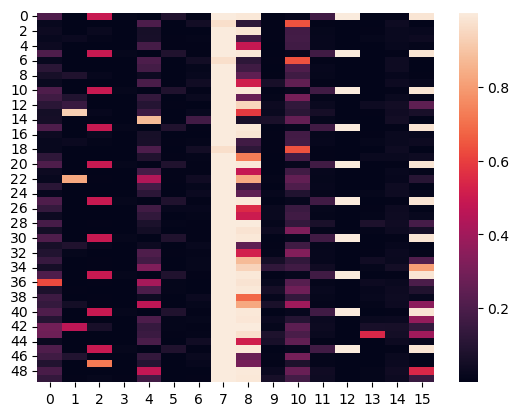

In [11]:
sns.heatmap(stats.decoder_attentions[1][0][:,:,0, 2].cpu().numpy())

<AxesSubplot: >

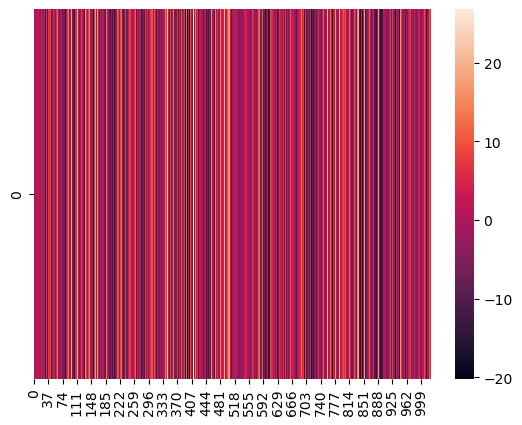

In [12]:
sns.heatmap(stats.decoder_hidden_states[11][0][0].cpu().numpy())

In [13]:
stats.decoder_hidden_states

((tensor([[[ 0.3401,  0.1310,  0.0761,  ..., 35.5583,  0.1119,  0.2755],
           [-0.4281, -0.5987, -0.6151,  ..., 35.5583,  0.1119,  0.2755]],
  
          [[ 0.3401,  0.1310,  0.0761,  ..., 35.5583,  0.1119,  0.2755],
           [-0.4281, -0.5987, -0.6151,  ..., 35.5583,  0.1119,  0.2755]],
  
          [[ 0.3401,  0.1310,  0.0761,  ..., 35.5583,  0.1119,  0.2755],
           [-0.4281, -0.5987, -0.6151,  ..., 35.5583,  0.1119,  0.2755]],
  
          ...,
  
          [[ 0.3401,  0.1310,  0.0761,  ..., 35.5583,  0.1119,  0.2755],
           [-0.4281, -0.5987, -0.6151,  ..., 35.5583,  0.1119,  0.2755]],
  
          [[ 0.3401,  0.1310,  0.0761,  ..., 35.5583,  0.1119,  0.2755],
           [-0.4281, -0.5987, -0.6151,  ..., 35.5583,  0.1119,  0.2755]],
  
          [[ 0.3401,  0.1310,  0.0761,  ..., 35.5583,  0.1119,  0.2755],
           [-0.4281, -0.5987, -0.6151,  ..., 35.5583,  0.1119,  0.2755]]],
         device='cuda:0'),
  tensor([[[-2.7524,  0.3968,  1.0524,  ..., 38.7825, -1.

## Control

In [12]:
# control
line = "།མཐོང་མ་ཐག་ཏུ་ཡང་དེ་རྣམས་བཅོམ་ལྡན་འདས་ལ་སེམས་དང་བ་ཆེན་པོ་སྐྱེས་སོ།"

In [16]:
translation, hs_df = stats_for_line(line, translator)
translation

/home/eeisenst/workspace/transformers/src/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


'as soon as they saw the blessed one, they experienced a surge of faith in him'

In [17]:
hs_df.act_stdev.sort_values().describe()

count    57850.000000
mean        85.371704
std         78.675591
min          0.199730
25%         19.273182
50%         52.695229
75%        161.379517
max        283.643402
Name: act_stdev, dtype: float64

In [18]:
hs_df.act_meandev.sort_values().describe()

count    57850.000000
mean        18.188547
std         11.979088
min          0.115712
25%         10.653923
50%         17.280499
75%         23.118048
max         73.778381
Name: act_meandev, dtype: float64

## Bad line

In [4]:
line = "།གནོད་པ་བྱས་པས་གལ་ཏེ་དེར་བཀོན་ན། །དེ་ལ་བཀོན་པས་བྱས་ཟིན་ལྡོག་གམ་ཅི།"

In [22]:
line = "།ཨ་སོགས་རྣམས་ནི་གཙུག་ཏོར་འཁོར་ལོ་སྙིང་མགྲིན་མགོ་བོ་ལྟེ་བའི་འཁོར་ལོ་དག་ལ་རིམ་པ་སྟེ། །སྣ་ཚོགས་གནག་དམར་རི་བོང་ཅན་དང་གསེར་འདྲ་ཕུང་པོ་ཁམས་ཀྱི་ལྷག་པའི་ལྷ་དང་ལྡན་པ་ལའོ།"

In [23]:
translation, hs_df = stats_for_line(line, translator)
translation

/home/eeisenst/workspace/transformers/src/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


'homage to all the buddhas and bodhisattvas thus did i hear at one time the blessed one was residing on vulture peak mountain together with a great sangha of,'

In [24]:
hs_df.act_stdev.sort_values().describe()

count    63700.000000
mean        40.878345
std         42.915630
min          0.184024
25%         15.347816
50%         27.587369
75%         55.783168
max        290.167786
Name: act_stdev, dtype: float64

In [25]:
hs_df.act_meandev.sort_values().describe()

count    63700.000000
mean        20.875090
std         14.473700
min          0.115826
25%          9.638684
50%         18.027775
75%         30.559387
max         71.023926
Name: act_meandev, dtype: float64

# Bigger experiment

## Control doc

In [6]:
with open("../../lotsawa/translations/vinaya_extract.en", "r") as f:
    bos_ens = list(filter(lambda x: len(x) > 0, map(lambda x: x.strip(), f.readlines())))
bos = [bos_ens[i] for i in range(0, len(bos_ens), 2)]
ens = [bos_ens[i] for i in range(1, len(bos_ens), 2)]

In [11]:
control_df = aggregated_df(bos, translator)

  0%|          | 0/196 [00:00<?, ?it/s]

In [13]:
control_df.stat.describe()

count    196.000000
mean      22.175781
std        0.422770
min       20.949240
25%       21.875979
50%       22.174538
75%       22.483031
max       23.304409
Name: stat, dtype: float64

In [12]:
control_df.stat2.describe()

count    196.000000
mean       0.045897
std        0.201267
min       -0.397310
25%       -0.077948
50%        0.028071
75%        0.169746
max        0.649829
Name: stat2, dtype: float64

In [8]:
control_df.sort_values(by="stat").tail(20).to_dict(orient="index")

{33: {'line': '།དེ་ནས་བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།',
  'translation': 'homage to all the buddhas and bodhisattvas thus did i hear at one time',
  'stat': -417.5988464355469,
  'stat2': 0.02977926842868328},
 188: {'line': 'དེས་སྨྲས་པ་ཤེས་ཏེ་ཁྱོད་དང་ཁོ་བོ་ཡང་དག་པར་རྫོགས་པའི་སངས་རྒྱས་འོད་སྲུང་གི་བསྟན་པ་ལ་རབ་ཏུ་བྱུང་བ་ཡིན་ནོ།',
  'translation': 'knowing this, he said, you and i have gone forth under the teachings of the totally and completely awakened buddha kasyapa.',
  'stat': -416.85455322265625,
  'stat2': 0.03658843785524368},
 154: {'line': 'བཅོམ་ལྡན་འདས་ཀྱིས་བུ་མོ་བཟང་མོ་དེ་ལ་ཅང་མི་གསུང་བས་གནང་ངོ་།',
  'translation': 'the blessed one assented to the girl subhadra by remaining silent.',
  'stat': -416.1421813964844,
  'stat2': 0.24400968849658966},
 176: {'line': 'འདི་ལྟར་ལས་དགེ་བ་དང་མི་དགེ་བ་བྱས་ཤིང་བསགས་པ་དག་ནི་ཟིན་པའི་ཕུང་པོ་དང་ཁམས་དང་སྐྱེ་མཆེད་དག་ལ་རྣམ་པར་སྨིན་པར་འགྱུར་ཏེ།',
  'translation': 'virtuous and non-virtuous actions performed and accumulated come to ripen upon the aggr

## Test doc

In [9]:
with open("../../lotsawa/translations/kalacakra_extract.en", "r") as f:
    bos_ens = list(filter(lambda x: len(x) > 0, map(lambda x: x.strip(), f.readlines())))[:100*2]
bos = [bos_ens[i] for i in range(0, len(bos_ens), 2)]
ens = [bos_ens[i] for i in range(1, len(bos_ens), 2)]
len(bos)

100

In [10]:
test_df = aggregated_df(bos, translator)

  0%|          | 0/100 [00:00<?, ?it/s]

In [11]:
test_df.stat2.describe()

count    100.000000
mean      -0.221376
std        0.192472
min       -0.580702
25%       -0.367187
50%       -0.233252
75%       -0.081881
max        0.301130
Name: stat2, dtype: float64

In [12]:
test_df.sort_values(by="stat").tail(30).to_dict(orient="index")

{81: {'line': '།ལྷག་མ་དྲུག་ཅུས་བསྒྱུར་བ་གང་ཡིན་དེ་ལས་ཆུ་ཚོད་སླར་ཡང་དེ་བསྒྱུར་བ་ལས་ཆུ་སྲང་སྟེ། །ཐོབ་པས་དམན་པའི་འཁོར་ལོ་གདོང་དུ་འགྱུར་ཏེ་མུན་ཅན་མཇུག་མ་དག་ཀྱང་རྒྱུ་སྐར་ཕྱེད་བསྲེས་པའོ།',
  'translation': 'the blessed one was residing at vulture peak mountain in rajagrha, together with a great sangha of sixty-six thousand monks and five hundred bodhisattvas',
  'stat': -457.31072998046875,
  'stat2': -0.36709365248680115},
 55: {'line': '།ནག་པ་ལ་སོགས་ཟླ་བ་བསྲེས་ཏེ་འོག་ཏུ་དུས་ཀྱིས་བསྒྱུར་བ་མཁའ་མེ་ཟླ་བས་རྣམ་པར་དབྱེ།',
  'translation': 'naksatradrajadsamkusumitabhidjna, the bodhisattva mahasattva sarvadsattvadpriyaddarsana said to candraprabha,',
  'stat': -456.7513122558594,
  'stat2': -0.25326791405677795},
 79: {'line': '།ཆུ་གཏེར་སྲོག་དང་ཆུ་སྲང་མེ་ནི་ཉིན་ཞག་སོ་སོའི་དུས་སུ་འཕེལ་འགྲིབ་བགྲོད་པའི་ཡན་ལག་གིས། །ལྷོ་ཕྱོགས་སུ་ནི་མཚན་མོ་དག་ཀྱང་འཕེལ་བར་འགྱུར་ཏེ་ཁ་བའི་རི་ཡི་བྱང་དུ་ཉིན་མོའོ།',
  'translation': 'then the blessed one said to the bodhisattva samantadbhadra, o son of the victorious ones, li

# Multi-pass beam search

In [9]:
line = "།དབྱངས་ནི་ཀ་ཙ་ཊ་པ་ཏར་ལྡན་ཐྐ་ལ་སོགས་པ་ཡང་དག་སྦྱར་བ་རྣམས་ཀྱི་སྐྱེ་བའི་གནས།"

In [283]:
line = "།ཨ་སོགས་རྣམས་ནི་གཙུག་ཏོར་འཁོར་ལོ་སྙིང་མགྲིན་མགོ་བོ་ལྟེ་བའི་འཁོར་ལོ་དག་ལ་རིམ་པ་སྟེ། །སྣ་ཚོགས་གནག་དམར་རི་བོང་ཅན་དང་གསེར་འདྲ་ཕུང་པོ་ཁམས་ཀྱི་ལྷག་པའི་ལྷ་དང་ལྡན་པ་ལའོ།"

In [15]:
translator.num_beams = 50
translator.decoding_length = 15
translator.add_score = False

# ls_logits_proc = LabelSmoothingLogitsProcessor(2)

translations = translator.translate(
    line,
    generator_kwargs={
        'repetition_penalty': 2.2,
        'no_repeat_ngram_size': 3,
        'num_return_sequences': translator.num_beams,
        # 'logits_processor': LogitsProcessorList([ls_logits_proc]),
        # 'num_beam_groups': 25,
        # 'diversity_penalty': 5.0,
        # 'num_beam_groups': 5,
        # 'diversity_penalty': 1.0,
    }
)

reranked = rerank(line, translations, reranker, num_return_sequences=translator.num_beams, add_scores=True)

# line, translations
line, reranked

  0%|          | 0/50 [00:00<?, ?it/s]

('།དབྱངས་ནི་ཀ་ཙ་ཊ་པ་ཏར་ལྡན་ཐྐ་ལ་སོགས་པ་ཡང་དག་སྦྱར་བ་རྣམས་ཀྱི་སྐྱེ་བའི་གནས།',
 ['it is the birthplace of those who are endowed|-1.571793556213379',
  'it is the birthplace of those with vowels,|-1.596767544746399',
  'it is the abode of those who are endowed|-1.6090203523635864',
  'this is the birthplace of those who are endowed|-1.7143234014511108',
  'it is the birthplace of the voices of the|-1.744752049446106',
  'with melodious vowels and consonants,|-1.8429933786392212',
  'with melodious vowels and syllables,|-1.8628513813018799',
  'when the blessed one had spoken these words,|-1.9029614925384521',
  'it is the birthplace of verses such as the|-1.9125034809112549',
  'it is the birthplace of the vowels khad|-1.934617042541504',
  'it is the birthplace of those endowed with vo|-1.9740809202194214',
  'this place is the birthplace of the voices of|-2.030876636505127',
  'endowed with vowels and consonants, they|-2.0618646144866943',
  'endowed with vowels and consonants, the|-2.0

In [ ]:
translation = translator.translate(
    line,
    generator_kwargs={
        'repetition_penalty': 2.2,
        'no_repeat_ngram_size': 3,
        # 'num_beam_groups': 5,
        # 'diversity_penalty': 1.0,
        # 'num_beam_groups': 25,
        # 'diversity_penalty': 5.0,
    },
    prefix_excluded="homage to "
)

translation

'it is the birthplace of those endowed with vowels and consonants|-0.638278603553772'

In [11]:
compute_loss(
    '།དབྱངས་ནི་ཀ་ཙ་ཊ་པ་ཏར་ལྡན་ཐྐ་ལ་སོགས་པ་ཡང་དག་སྦྱར་བ་རྣམས་ཀྱི་སྐྱེ་བའི་གནས།',
    'homage to all the buddhas and bodhisattvas thus did i hear at one time',
    translator
)

/home/eeisenst/workspace/compassionai/garland/src/cai_garland/models/cai_nllb_tokenizer.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(
/home/eeisenst/workspace/transformers/src/transformers/models/encoder_decoder/modeling_encoder_decoder.py:642: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


-3.368346929550171

In [12]:
compute_loss(
    '།དབྱངས་ནི་ཀ་ཙ་ཊ་པ་ཏར་ལྡན་ཐྐ་ལ་སོགས་པ་ཡང་དག་སྦྱར་བ་རྣམས་ཀྱི་སྐྱེ་བའི་གནས།',
    'it is the birthplace of those who are endowed with vowels and consonants',
    translator
)

-1.3101927042007446

In [13]:
compute_loss(
    '།དབྱངས་ནི་ཀ་ཙ་ཊ་པ་ཏར་ལྡན་ཐྐ་ལ་སོགས་པ་ཡང་དག་སྦྱར་བ་རྣམས་ཀྱི་སྐྱེ་བའི་གནས།',
    'it is the abode of birth for those who are endowed with vowel sounds, phrases, syllables, consonants, and so forth.',
    translator
)

-0.9051944613456726

# Dataset testing

In [1]:
from datasets import load_dataset, Split

## Mined

In [2]:
dataset = load_dataset(
    "../src/cai_garland/data/parallel_dataset_loader_hf.py",
    "mined",
    split=Split.TRAIN
)

Found cached dataset parallel_dataset_loader_hf (/home/eeisenst/.cache/huggingface/datasets/parallel_dataset_loader_hf/mined/0.1.0/d51557f90334b45001cdb73ea8c5d9d8cbe70b3e7ff1a2d62b1f8d3e4db335d4)


In [3]:
dataset[1]

{'source': '།གང་གིས་འཆིང་རྣམས་ཡང་དག་རབ་བཅད་ཅིང་། །མུ་སྟེགས་ཚོགས་རྣམས་ཐམས་ཅད་རབ་བཅོམ་སྟེ། །སྡེ་དང་བཅས་པའི་བདུད་རྣམས་ངེས་བཅོམ་ནས། །བྱང་ཆུབ་འདི་བརྙེས་དེ་ལ་ཕྱག་འཚལ་ལོ།',
 'target': 'homage to him who severed the bonds, destroyed the whole host of tirthikas, vanquished the armies of mara, and thus discovered this awakening',
 'score': -1.3410027027130127}

In [4]:
all_data = dataset.filter(lambda ex: ex['score'] > -100).to_pandas()
all_data

Loading cached processed dataset at /home/eeisenst/.cache/huggingface/datasets/parallel_dataset_loader_hf/mined/0.1.0/d51557f90334b45001cdb73ea8c5d9d8cbe70b3e7ff1a2d62b1f8d3e4db335d4/cache-f0a8990e75efb72d.arrow


,source,target,score
0,།གང་གིས་འཆིང་རྣམས་ཡང་དག་རབ་བཅད་ཅིང་། །མུ་སྟེགས...,"homage to him who severed the bonds, destroyed...",-1.341003
1,།ངུར་སྨྲིག་གོས་འཆང་མཁས་པ་ཚུལ་ལས་ཉམས་པ་དཀའ།,for a learned wearer of the saffron robes to f...,-1.401854
2,།གཞི་རྣམས་ཀྱི་སྤྱི་སྡོམ་ལ། རབ་འབྱུང་གསོ་སྦྱོང་...,the chapters on monastic discipline includes c...,-1.411704
3,།ཁྱིམ་དོན་ཆེ་ཆུང་སྤངས་ཏེ་དང་པོར་རབ་འབྱུང་དཀའ།,at first to renounce a householders concerns a...,-1.919196
4,།མངོན་དགའ་ཇི་བཞིན་དོན་བསྐྱེད་ཡང་དག་བྱེད་པ་དཀའ།,for the joyful set on perfection to act perfec...,-2.118942
...,...,...,...
223043,།ཁྲུ་སྟོང་གི་དཀྱིལ་འཁོར་ནི་ཁྲུ་ཉིས་སྟོང་གི་ཐིག...,"the benevolence of brahma, and the supremacy o...",-3.237949
223044,།དཀྱིལ་འཁོར་ནི་རྟག་ཏུ་རང་གི་བདག་ཉིད་ཀྱི་ཆས་ཁྲུ...,and the ascetic practices of kasyapa by the pr...,-3.247481
223045,།རྨོངས་པ་དང་རེངས་པ་ལ་སོགས་པ་ལ་ཁེངས་པ་ཁ་དོག་སེར...,"may there be well-being here, and may all be d...",-3.596120
223046,།རྫས་ཀྱི་སྦྱིན་སྲེག་གི་བླུགས་གཟར་གྱི་ཡུ་བའི་རྒ...,act always lovingly toward all creatures and p...,-4.257689


<AxesSubplot: >

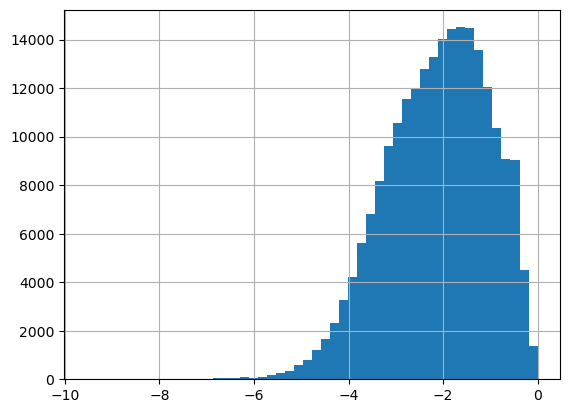

In [5]:
all_data.score.hist(bins=50)

In [6]:
homages = dataset.filter(lambda ex: ex['target'].startswith('homage')).to_pandas()
homages

Loading cached processed dataset at /home/eeisenst/.cache/huggingface/datasets/parallel_dataset_loader_hf/mined/0.1.0/d51557f90334b45001cdb73ea8c5d9d8cbe70b3e7ff1a2d62b1f8d3e4db335d4/cache-27b78b6e20902232.arrow


,source,target,score
0,།གང་གིས་འཆིང་རྣམས་ཡང་དག་རབ་བཅད་ཅིང་། །མུ་སྟེགས...,"homage to him who severed the bonds, destroyed...",-1.341003
1,གཙུག་ལག་ཁང་ནི་ཅི་འདྲ།,"homage to you, instructor,",-2.913674
2,།འཕགས་པ་གང་པོ་དེ་ལ་ཕྱག་འཚལ་ལོ།,homage to the noble one purna,-0.904922
3,ཆོས་ལ་ཕྱག་འཚལ་ལོ།,homage to the dharma,-0.412012
4,།དགེ་འདུན་ལ་ཕྱག་འཚལ་ལོ།,homage to the community,-1.634261
...,...,...,...
505,།ད་ནི་གསུང་གི་དཀྱིལ་འཁོར་ལ་ཙ་རྩི་ཀཱ་ལ་སོགས་པའི...,homage to the bhagavan tathagata great cloud p...,-3.980511
506,།དེ་བཞིན་དུ་ཁྱབ་འཇུག་མའི་ཀྵི་ཡཱ་ཡཱི་ཡྼཱྀ་ཀྵཱི་...,homage to the bhagavan tathagata complete clou...,-4.016593
507,བྱང་དུ་ྈྐ་ལ་སོགས་པ་ཐུང་ངུ་ལྔ་སྟེ།,"homage to you, glorious goddess sarasvati",-4.102365
508,།དེ་བཞིན་དུ་རྩ་བའི་རྒྱུད་ལས་གསུངས་པ།,homage to all the buddhas and bodhisattvas,-1.864152


<AxesSubplot: >

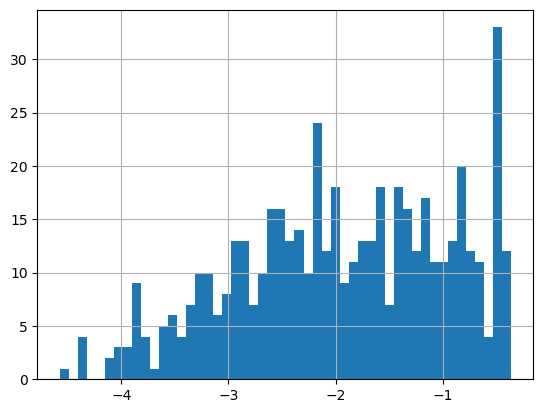

In [7]:
homages.score.hist(bins=50)

In [8]:
residings = dataset.filter(
    lambda ex: ex['target'].startswith('the bhagavan was residing') or ex['target'].startswith('the blessed one was residing')
).to_pandas()
residings

Loading cached processed dataset at /home/eeisenst/.cache/huggingface/datasets/parallel_dataset_loader_hf/mined/0.1.0/d51557f90334b45001cdb73ea8c5d9d8cbe70b3e7ff1a2d62b1f8d3e4db335d4/cache-e49d1a1529a08dbb.arrow


,source,target,score
0,།འདི་སྐད་བདག་གིས་ཐོས་པ་དུས་གཅིག་ན།,"the blessed one was residing in venuvana,",-2.167787
1,།འཕགས་པ་དཀོན་མཆོག་བརྩེགས་པ་ཆེན་པོའི་ཆོས་ཀྱི་རྣ...,the blessed one was residing in rajagrha at vu...,-2.372726
2,།འདི་སྐད་བདག་གིས་ཐོས་པ་དུས་གཅིག་ན།,the blessed one was residing at the venuvana i...,-2.145211
3,བཅོམ་ལྡན་འདས་རྒྱལ་པོའི་ཁབ་ན་བྱ་རྒོད་ཀྱི་ཕུང་པོ...,the bhagavan was residing together with a grea...,-0.964649
4,བཅོམ་ལྡན་འདས་རྒྱལ་པོའི་ཁབ་ན། བྱ་རྒོད་ཀྱི་ཕུང་པ...,the blessed one was residing at vulture peak m...,-0.573247
5,སངས་རྒྱས་དང་བྱང་ཆུབ་སེམས་དཔའ་ཐམས་ཅད་ལ་ཕྱག་འཚལ་ལོ།,"the blessed one was residing at jetavana,",-2.606208
6,།འདི་སྐད་བདག་གིས་ཐོས་པ་དུས་གཅིག་ན།,"the blessed one was residing at sravasti,",-1.995737
7,།འདི་སྐད་བདག་གིས་ཐོས་པ་དུས་གཅིག་ན།,"the blessed one was residing in sravasti,",-1.758794
8,བཅོམ་ལྡན་འདས་མཉན་ཡོད་ན། རྒྱལ་བུ་རྒྱལ་བྱེད་ཀྱི་...,"the bhagavan was residing in sravasti, in the ...",-0.762687
9,།༄༅༅། །རྒྱ་གར་སྐད་དུ། ཨཱརྱ་སརྦ་དྷརྨ་སྭ་བྷཱ་བ་ས...,the bhagavan was residing at vulture peak moun...,-2.378390


In [9]:
all_data[all_data.score < -4].sort_values('score')

,source,target,score
16554,ཡང་དག་པར་རྫོགས་པའི་སངས་རྒྱས་ལ་མེད་ཅིང་མི་དམིགས...,the vitaraga level,-9.540758
13335,གསོལ་པ། བཅོམ་ལྡན་འདས་དེ་ནི་མ་ལགས་སོ།,consciousness,-9.330505
13303,གསོལ་པ། བཅོམ་ལྡན་འདས་དེ་ནི་མ་ལགས་སོ།,a nose,-9.233069
6198,།མཛོད་སྤུར་ནུབ་པར་གྱུར་ཏོ།,,-9.120602
12705,།གཟུགས་ད་ལྟར་བྱུང་བ་ཞེས་བྱ་བར་མི་སྦྱོར་རོ།,volitional factors,-9.087727
...,...,...,...
91205,།ཨ་ལ་ལ་དེ་བཞིན་གཤེགས་པ་དགྲ་བཅོམ་པ་ཡང་དག་པར་རྫོ...,"moreover, in each of their own languages all b...",-4.000272
70525,།བདེ་གཤེགས་རྣམ་པར་གྲགས་པའི་རྒྱལ་པོ་ཡི། །སྐྱེ་བ...,and his light will extend eight leagues faith ...,-4.000258
182689,གསོན་པ་རྣམས་ནི་ཐམས་ཅད་ཀྱང་འཆི་བའི་མཐར་ཐུག་པར་འ...,just like foam and bursting bubbles everyone a...,-4.000177
104524,།བདག་དང་འདྲ་བར་རྟོགས་པར་བགྱི།,"although we say words like these,",-4.000141


## Merged

In [10]:
dataset = load_dataset(
    "../src/cai_garland/data/parallel_dataset_loader_hf.py",
    "largest_parallel_with_context",
    split=Split.TRAIN
)

Found cached dataset parallel_dataset_loader_hf (/home/eeisenst/.cache/huggingface/datasets/parallel_dataset_loader_hf/largest_parallel_with_context/0.1.0/d51557f90334b45001cdb73ea8c5d9d8cbe70b3e7ff1a2d62b1f8d3e4db335d4)


In [11]:
dataset[1]

{'source': 'གང་བྱང་ཆུབ་སེམས་དཔའ་སྦྱིན་པའི་ངང་ཚུལ་ཅན་དུ་འགྱུར་བ་འདི་ནི་ཆོས་ཉིད་ཡིན་ནོ་སྙམ་སྟེ། དེ་རྒྱུ་དེ་དང་རྐྱེན་དེ་དང་གཞིས་ཕན་བཏགས་པའི་ལན་དུ་ཕན་འདོགས་པ་ཐམས་ཅད་ལ་མི་རེ་བར་སྦྱིན་པ་སྦྱིན་པར་བྱེད་དེ།',
 'target': 'bodhisattvas are generous, that is just how it is, and so they are generous without any hope that the causes, conditions, or bases of their generosity will bring any reward.'}

In [12]:
homages = dataset.filter(lambda ex: ex['target'].startswith('homage')).to_pandas()
homages

Filter:   0%|          | 0/361308 [00:00<?, ? examples/s]

,source,target
0,བཅོམ་ལྡན་འདས་དེ་བཞིན་གཤེགས་པ་ཡེ་ཤེས་ཏ་ལ་ལ་ལ་ཕྱ...,"homage to the blessed one, the tathagata jnano..."
1,ན་མོ་པཱི་ཏ་ནཱ་གཱ་ཡ། མེེ་ཏྲི་ཡ་སི་ཧ་ལོ་ཙ་ནེ་སྭཱ...,"homage to vitaraga, o maitreyadsimhadlocani, s..."
2,སངས་རྒྱས་དང་། བྱང་ཆུབ་སེམས་དཔའ་ཐམས་ཅད་ལ་ཕྱག་འཚ...,homage to all the buddhas and bodhisattvas.
3,དེ་བཞིན་གཤེགས་པ་རིན་པོ་ཆེའི་མེ་ཏོག་ཡོན་ཏན་གྱི་...,homage to tathagata ratnadkusumadgunadsagaradv...
4,སངས་རྒྱས་དང་བྱང་ཆུབ་སེམས་དཔའ་ཐམས་ཅད་ལ་ཕྱག་འཚལ་...,homage to the buddhas and the bodhisattvas. th...
...,...,...
610,།དེ་བཞིན་གཤེགས་པ་འཇིགས་པའི་སྒྲ་སྒྲོགས་རྒྱལ་པོ་...,homage to the tathagata bhiksmasdvaragarjitadr...
611,།དེ་བཞིན་དུ་ཨོྃ་ཡིག་ནི་ཆོས་ཀྱི་དུང་དང་ཧུྃ་ནི་ཡ...,homage to the bhagavan tathagata clouds great ...
612,།ཆགས་པ་མེད་པའི་ས་ལས་རྐང་པ་བཏེག་པ་དང་རྐང་པ་བོར་...,homage to all buddhas and bodhisattvas thus di...
613,མེ་ཏོག་ལ་ལན་བདུན་བཟླས་ཏེ་དབུལ་བར་བྱའོ། ཨ་མོ་གྷ...,"homage to the great bodhisattva being, come, o..."


In [13]:
residings = dataset.filter(
    lambda ex: ex['target'].startswith('the bhagavan was residing') or ex['target'].startswith('the blessed one was residing')
).to_pandas()
residings

Filter:   0%|          | 0/361308 [00:00<?, ? examples/s]

,source,target
0,བཅོམ་ལྡན་འདས་རྒྱལ་པོའི་ཁབ་ན། བྱ་རྒོད་ཀྱི་ཕུང་པ...,the blessed one was residing at vulture peak m...
1,བཅོམ་ལྡན་འདས་མཉན་ཡོད་ན་རྒྱལ་བུ་རྒྱལ་བྱེད་ཀྱི་ཚ...,"the blessed one was residing in sravasti, in t..."
2,བཅོམ་ལྡན་འདས་རྒྱལ་པོའི་ཁབ། བྱ་རྒོད་ཀྱི་ཕུང་པོའ...,the blessed one was residing at vulture peak n...
3,བཅོམ་ལྡན་འདས་མཉན་དུ་ཡོད་པ་ན་རྒྱལ་བུ་རྒྱལ་བྱེད་...,"the blessed one was residing in jeta grove, an..."
4,བཅོམ་ལྡན་འདས་མཉན་ཡོད་ན་བཞུགས་ཏེ། དབྱར་གནས་པར་བ...,"the blessed one was residing at sravasti, wher..."
5,བཅོམ་ལྡན་འདས་རྒྱལ་པོའི་ཁབ་བྱ་རྒོད་ཕུང་པོའི་རི་...,the bhagavan was residing on vulture peak moun...
6,བཅོམ་ལྡན་འདས་མཉན་ཡོད་ན། རྒྱལ་བུ་རྒྱལ་བྱེད་ཀྱི་...,"the bhagavan was residing in sravasti, in the ..."
7,བཅོམ་ལྡན་འདས་རྒྱལ་པོའི་ཁབ་ན་བྱ་རྒོད་ཀྱི་ཕུང་པོ...,the bhagavan was residing on vulture peak moun...
8,བཅོམ་ལྡན་འདས་རྒྱལ་པོའི་ཁབ་ན། བྱ་རྒོད་ཀྱི་ཕུང་པ...,the bhagavan was residing at vulture peak moun...
9,བཅོམ་ལྡན་འདས་མཉན་ཡོད་ན་རྒྱལ་བུ་རྒྱལ་བྱེད་ཀྱི་ཚ...,the bhagavan was residing at the grove of anat...


# Translation results

In [20]:
import pandas as pd

In [14]:
with open("../../lotsawa/translations/kalacakra_extract.en", "r") as f:
    bos_ens = list(filter(lambda x: len(x) > 0, map(lambda x: x.strip(), f.readlines())))
bos = [bos_ens[i] for i in range(0, len(bos_ens), 2)]
ens = [bos_ens[i] for i in range(1, len(bos_ens), 2)]

In [17]:
ens, scores = [en.split('|')[0] for en in ens], [float(en.split('|')[1]) for en in ens]

In [19]:
bos[0], ens[0], scores[0]

('།༄༅༅། །རྒྱ་གར་སྐད་དུ། པ་ར་མ་ཨཱ་དི་བུདྡྷ་ཨུདྡྷྀ་ཏ་ཤྲཱི་ཀཱ་ལ་ཙཀྲ་ནཱ་མ་ཏནྟྲ་རཱ་ཛཱ། བོད་སྐད་དུ། མཆོག་གི་དང་པོའི་སངས་རྒྱས་ལས་ཕྱུང་བ་རྒྱུད་ཀྱི་རྒྱལ་པོ་དཔལ་དུས་ཀྱི་འཁོར་ལོ་ཞེས་བྱ་བ།',
 'he was learned and venerable, a blissful one, a knower of the world, a steersman who guided beings, unexcelled, a teacher of gods and humans, a buddha, a blessed one',
 -0.21725641191005707)

In [28]:
translation_df = pd.DataFrame({
    'bo': bos,
    'en': ens,
    'score': scores
})

In [29]:
translation_df['normed_score'] = translation_df.score / translation_df.en.str.len()

In [30]:
translation_df

,bo,en,score,normed_score
0,།༄༅༅། །རྒྱ་གར་སྐད་དུ། པ་ར་མ་ཨཱ་དི་བུདྡྷ་ཨུདྡྷྀ...,"he was learned and venerable, a blissful one, ...",-0.217256,-0.001317
1,དཔལ་དུས་ཀྱི་འཁོར་ལོ་ལ་ཕྱག་འཚལ་ལོ།,homage to glorious chakra of time.,-0.350871,-0.010320
2,།ཐམས་ཅད་མཁྱེན་པ་ཡེ་ཤེས་སྐུ་དང་ཉིན་མོར་བྱེད་པའི...,"the tathagata, the arhat, the perfectly enligh...",-0.551015,-0.001783
3,།ཕྱི་དང་ལུས་དང་གཞན་ལ་ཡང་སྟེ་རང་བཞིན་རྣམས་ལ་སྐྱ...,we supplicate you-send down rainfall here in t...,-0.577142,-0.001798
4,།ཟླ་བ་བཟང་པོ་ཁྱོད་ལ་བདག་མགུ་གང་ཞིག་ཁྱོད་ཀྱིས་ད...,"it is because the supreme gods, humans, raksas...",-0.625009,-0.005208
...,...,...,...,...
408,།ཟླ་བ་དྲུག་པ་ལ་ཡང་ཤ་དང་ཁྲག་ཏུ་འགྱུར་ཏེ་ཚོར་བ་བ...,"during the sixth month, there will be flesh an...",-0.640607,-0.003319
409,།གནད་དང་རུས་པ་རྐང་དུ་འགྱུར་ཏེ་རོ་འཛིན་དང་ནི་གཅ...,"as well as feces, marrow, bone, and sinew, uri...",-0.695733,-0.004191
410,།མངལ་དུ་མངལ་ན་གནས་པའི་སྡུག་བསྔལ་བཅའ་བའི་དུས་དང...,the time is ripe for the pains of being in the...,-0.553986,-0.005327
411,།གཞོན་ནུ་དང་ནི་ལང་ཚོ་དག་ལ་བུད་མེད་ནོར་དང་འབྱོར...,"those whose wealth and riches have decreased, ...",-0.722321,-0.003154


In [36]:
translation_df.sort_values('normed_score').tail(20).en.tolist()

['we supplicate you-send down rainfall here in the continent of jambudvipa, svaha great naga king sagara then addressed the bodhisattva mahasattva sarvadnivaranadviskamdbhin noble avalokitesvara, the great brahmin prophesied by the perfectly enlightened buddha candradsuryadvimaladnaksatradrajadsamkusumitabhidjnad, saying,',
 'the tathagata, the arhat, the perfectly enlightened buddha jaladdharadgarjitadghosadsusvaranadksatradrajadsamkusumitabhidjnadviniscayadrajendra then said to the bodhisattva mahasattva sarvadnivaranadviskamdbhin, omniscient one, all-knowing one, with your body of wisdom, supreme vajra holder, awakened buddha,',
 'the spiritual practitioner who carefully considers and attends to the internal body, with insight derived from hearing or by seeing with the divine eye, this concludes the thirty-second chapter of the dharma teaching of the white lotus of the good dharma then the blessed one said to the bodhisattva samantadbhadra, o son of the victorious ones,',
 'at that 